# Purpose

2021-08-02: Now that I'm processing millions of comments and posts, I need to re-write the functions to try to do some work in parallel and reduce the amount of data loaded in RAM.

- `Dask` seems like a great option to load data and only compute some of it as needed.
- `cuDF` could be a way to speed up some computation using GPUs
- `Dask-delayed` could be a way to create a task DAG lazily before computing all the aggregates.


---

In notebook 09 I combined embeddings from posts & subreddits (`djb_09.00-combine_post_and_comments_and_visualize_for_presentation.ipynb`).

In this notebook I'll be testing functions that include mlflow so that it's easier to try a lot of different weights to find better respresentations.

Take embeddings created by other models & combine them:
```
new post embeddings = post + comments + subreddit description

new subreddit embeddings = new posts (weighted by post length or upvotes?)
```

# Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import os
import logging
from pprint import pprint

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import dask
from dask import dataframe as dd
from tqdm.auto import tqdm

import mlflow
import hydra

import subclu
from subclu.models.aggregate_embeddings import (
    AggregateEmbeddings, AggregateEmbeddingsConfig,
    load_config_agg_jupyter
)

from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric
)
from subclu.utils.mlflow_logger import MlflowLogger, save_pd_df_to_parquet_in_chunks
from subclu.eda.aggregates import (
    compare_raw_v_weighted_language
)
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)


print_lib_versions([dask, hydra, mlflow, np, pd, plotly, sns, subclu])

python		v 3.7.10
===
dask		v: 2021.06.0
hydra		v: 1.1.0
mlflow		v: 1.16.0
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.3.2


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas')

,experiment_id,name,artifact_location,lifecycle_stage
0,0,Default,./mlruns/0,active
1,1,fse_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/1,active
2,2,fse_vectorize_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/2,active
3,3,subreddit_description_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/3,active
4,4,fse_vectorize_v1.1,gs://i18n-subreddit-clustering/mlflow/mlruns/4,active
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active
9,9,v0.3.2_use_multi_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/9,active


## Get runs that we can use for embeddings aggregation jobs

In [10]:
%%time

df_mlf_runs =  mlf.search_all_runs(experiment_ids=[9, '10', 11, 12])
df_mlf_runs.shape

CPU times: user 82.5 ms, sys: 5.38 ms, total: 87.9 ms
Wall time: 86.8 ms


(28, 75)

In [11]:
mask_finished = df_mlf_runs['status'] == 'FINISHED'
mask_output_over_1M_rows = (
    (df_mlf_runs['metrics.df_vect_posts_rows'] >= 1e6) |
    (df_mlf_runs['metrics.df_vect_comments'] >= 1e6)
)
# df_mlf_runs[mask_finished].shape

df_mlf_use_for_agg = df_mlf_runs[mask_output_over_1M_rows]
df_mlf_use_for_agg.shape

(3, 75)

In [12]:
cols_with_multiple_vals = df_mlf_use_for_agg.columns[df_mlf_use_for_agg.nunique(dropna=False) > 1]
# len(cols_with_multiple_vals)

style_df_numeric(
    df_mlf_use_for_agg
    [cols_with_multiple_vals]
    .drop(['artifact_uri', 'end_time',
           # 'start_time',
           ], 
          axis=1)
    .dropna(axis='columns', how='all')
    .iloc[:, :30]
    ,
    rename_cols_for_display=True,
)

,run id,experiment id,status,start time,metrics.vectorizing time minutes posts,metrics.df vect subreddits description rows,metrics.df vect subreddits description cols,metrics.df vect posts rows,metrics.vectorizing time minutes subreddit meta,metrics.vectorizing time minutes comments,metrics.vectorizing time minutes full function,metrics.total comment files processed,metrics.df vect comments,metrics.df vect posts cols,params.tokenize lowercase,params.tf limit first n chars,params.subreddits path,params.tf batch inference rows,params.posts path,params.batch comment files,tags.mlflow.runName,tags.mlflow.source.git.commit
5,a948e9fd651545f997430cddc6b529eb,10,FINISHED,2021-07-29 23:02:33.997000+00:00,14.74,"3,767.00",514.00,"1,649,929.00",0.08,145.73,176.77,37.00,"19,168,154.00",515.00,True,1000,subreddits/top/2021-07-16,2000,posts/top/2021-07-16,True,new_batch_fxn-2021-07-29_230233,63f5f420fb6b48d8243749cba183071757dac531
7,e66c5db26bd64f6da09c012eea700d0a,10,FINISHED,2021-07-29 18:59:48.715000+00:00,-,-,-,-,-,117.47,133.16,37.00,"19,200,854.00",-,False,850,None,6100,None,True,new_batch_fxn_2021-07-29_185948,64f49e85a8ef56a6795edf9da9a6f5964cb6830b
16,614a38e6690c4f3ba08725b1585b2ee9,9,KILLED,2021-07-29 11:49:53.924000+00:00,10.01,"3,767.00",514.00,"1,649,929.00",0.07,-,-,-,-,515.00,False,1000,subreddits/top/2021-07-16,2100,posts/top/2021-07-16,None,test_new_fxn2021-07-29_114953,64f49e85a8ef56a6795edf9da9a6f5964cb6830b


# Load configs for aggregation jobs

Note that by default `hydra` is a cli tool. If we want to call use it in jupyter, we need to manually initialize configs & compose the configuration. See my custom function `load_config_agg_jupyter`. Also see:
- [Notebook with `Hydra` examples in a notebook](https://github.com/facebookresearch/hydra/blob/master/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb).
- [Hydra docs, Hydra in Jupyter](https://hydra.cc/docs/next/advanced/jupyter_notebooks/).


In [13]:
mlflow_experiment_test = 'v0.3.2_use_multi_aggregates_test'
mlflow_experiment_full = 'v0.3.2_use_multi_aggregates'


config_test_sample_lc_false = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name='aggregate_embeddings',
    overrides=[f"mlflow_experiment={mlflow_experiment_test}",
               'n_sample_posts_files=2', 
               'n_sample_comments_files=2',
               'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_false',
              ]
)
config_test_full_lc_false = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name='aggregate_embeddings',
    overrides=[f"mlflow_experiment={mlflow_experiment_test}",
               'n_sample_posts_files=null', 
               'n_sample_comments_files=null',
               'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_false',
              ]
)

config_full_lc_false = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name='aggregate_embeddings',
    overrides=[f"mlflow_experiment={mlflow_experiment_full}",
               'n_sample_posts_files=null', 
               'n_sample_comments_files=null',
               'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_false',
              ]
)

config_full_lc_true = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name='aggregate_embeddings',
    overrides=[f"mlflow_experiment={mlflow_experiment_full}",
               'n_sample_posts_files=null', 
               'n_sample_comments_files=null',
               'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_true',
              ]
)
# pprint(config_test_sample_lc_false.config_dict, indent=2)

In [14]:
df_configs = pd.DataFrame(
    [config_test_sample_lc_false.config_flat,
     config_test_full_lc_false.config_flat,
     config_full_lc_false.config_flat,
     config_full_lc_true.config_flat,
    ]
)
cols_with_diffs_config = df_configs.columns[df_configs.nunique(dropna=False) > 1]
df_configs[cols_with_diffs_config]

,comments_uuid,posts_uuid,subreddit_desc_uuid,mlflow_experiment,n_sample_posts_files,n_sample_comments_files
0,e66c5db26bd64f6da09c012eea700d0a,614a38e6690c4f3ba08725b1585b2ee9,614a38e6690c4f3ba08725b1585b2ee9,v0.3.2_use_multi_aggregates_test,2.0,2.0
1,e66c5db26bd64f6da09c012eea700d0a,614a38e6690c4f3ba08725b1585b2ee9,614a38e6690c4f3ba08725b1585b2ee9,v0.3.2_use_multi_aggregates_test,NaN,NaN
2,e66c5db26bd64f6da09c012eea700d0a,614a38e6690c4f3ba08725b1585b2ee9,614a38e6690c4f3ba08725b1585b2ee9,v0.3.2_use_multi_aggregates,NaN,NaN
3,a948e9fd651545f997430cddc6b529eb,a948e9fd651545f997430cddc6b529eb,a948e9fd651545f997430cddc6b529eb,v0.3.2_use_multi_aggregates,NaN,NaN


In [15]:
pprint(config_test_sample_lc_false.config_flat, indent=2)

{ 'agg_comments_to_post_weight_col': None,
  'agg_post_comment_weight': 20,
  'agg_post_post_weight': 70,
  'agg_post_subreddit_desc_weight': 10,
  'agg_post_to_subreddit_weight_col': None,
  'bucket_name': 'i18n-subreddit-clustering',
  'col_comment_id': 'comment_id',
  'col_post_id': 'post_id',
  'col_subreddit_id': 'subreddit_id',
  'col_text_comment_word_count': 'comment_text_word_count',
  'col_text_post_word_count': 'text_word_count',
  'comments_folder_embeddings': 'df_vect_comments',
  'comments_uuid': 'e66c5db26bd64f6da09c012eea700d0a',
  'dataset_name': 'Top Subreddits (no Geo) + German Subs 2021-07-16, comments: '
                  '2021-07-09',
  'folder_comments_text_and_meta': 'comments/top/2021-07-09',
  'folder_posts_text_and_meta': 'posts/top/2021-07-16',
  'folder_subreddits_text_and_meta': 'subreddits/top/2021-07-16',
  'min_comment_text_len': 10,
  'mlflow_experiment': 'v0.3.2_use_multi_aggregates_test',
  'mlflow_tracking_uri': 'sqlite',
  'n_sample_comments_files'

In [ ]:
BREAK

# Initialize a local dask client
so that we can see the progress/process for dask jobs

In [16]:
%%time

from dask.distributed import Client
client = Client()

CPU times: user 574 ms, sys: 292 ms, total: 866 ms
Wall time: 1.64 s


In [17]:
client.dashboard_link

'http://127.0.0.1:8787/status'

# Run test with a sample of files

For testing, let's only load a few files at a time (e.g., 2 instead of 50) to test the process end-to-end.

The logic for sampling files and download/`caching` files locally lives in the `mlf` custom function.

Caching can save 9+ minutes if we try to download the files from GCS every time.

In [16]:
# try:
#     del d_dfs2, job_agg2
# except NameError:
#     pass
# gc.collect()

In [23]:
%%time

mlflow.end_run("FAILED")
gc.collect()
try:
    del job_agg2
    # del d_dfs2
except NameError:
    pass
gc.collect()

job_agg2 = AggregateEmbeddings(
    run_name=f"test_new_class_sample-{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    **config_test_sample_lc_false.config_flat
)
job_agg2.run_aggregation()

gc.collect()

19:53:07 | INFO | "== Start run_aggregation() method =="
19:53:07 | INFO | "MLflow tracking URI: sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db"
19:53:07 | INFO | "  Local model saving directory: /home/jupyter/subreddit_clustering_i18n/data/models/aggregate_embeddings/2021-08-04_195307-test_new_class_sample-2021-08-04_195307"
19:53:07 | INFO | "  Saving config to local path..."
19:53:07 | INFO | "  Logging config to mlflow..."
19:53:08 | INFO | "-- Start _load_raw_embeddings() method --"
19:53:08 | INFO | "Loading subreddit description embeddings..."
19:53:08 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_subreddits_description"


  0%|          | 0/4 [00:00<?, ?it/s]

19:53:09 | INFO | "  Reading 1 files"
19:53:09 | INFO | "       3,767 |  514 <- Raw vectorized subreddit description shape"
19:53:09 | INFO | "Loading POSTS embeddings..."
19:53:09 | INFO | "  Sampling POSTS FILES down to: 2"
19:53:10 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"


  0%|          | 0/51 [00:00<?, ?it/s]

19:53:10 | INFO | "  Reading 2 files"
19:53:11 | INFO | "      68,748 |  515 <- Raw POSTS shape"
19:53:11 | INFO | "Loading COMMENTS embeddings..."
19:53:11 | INFO | "  Sampling COMMENTS FILES down to: 2"
19:53:11 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/10/e66c5db26bd64f6da09c012eea700d0a/artifacts/df_vect_comments"


  0%|          | 0/38 [00:00<?, ?it/s]

19:53:11 | INFO | "  Reading 2 files"
19:53:11 | INFO | "  0:00:03.131586 <- Total raw embeddings load time elapsed"
19:53:12 | INFO | "-- Start _load_metadata() method --"
19:53:12 | INFO | "Loading POSTS metadata..."
19:53:12 | INFO | "Reading raw data..."
19:53:12 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"


  0%|          | 0/43 [00:00<?, ?it/s]

19:53:14 | INFO | "  Applying transformations..."
19:53:15 | INFO | "  (1649929, 14) <- Raw META POSTS shape"
19:53:15 | INFO | "Loading subs metadata..."
19:53:15 | INFO | "  reading sub-level data & merging with aggregates..."
19:53:15 | INFO | "Reading raw data..."
19:53:15 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-07-16"


  0%|          | 0/1 [00:00<?, ?it/s]

19:53:16 | INFO | "  Applying transformations..."
19:53:18 | INFO | "  (3767, 38) <- Raw META subreddit description shape"
19:53:18 | INFO | "Loading COMMENTS metadata..."
19:53:18 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/comments/top/2021-07-09"


  0%|          | 0/37 [00:00<?, ?it/s]

19:53:18 | INFO | "  (Delayed('int-ac2dd3ce-5c43-44d1-b1c6-0d06cf2460e0'), 7) <- Raw META COMMENTS shape"
19:53:18 | INFO | "  0:00:06.257307 <- Total metadata loading time elapsed"
19:53:18 | INFO | "-- Start _agg_comments_to_post_level() method --"
19:53:19 | INFO | "No column to weight comments, simple mean for comments at post level"
19:53:19 | INFO | "Checking that index is unique after aggregation..."
19:53:52 | INFO | "  (Delayed('int-97142f6f-0bf5-4f9c-aaab-0358774fa241'), 515) <- df_v_com_agg shape after aggregation"
19:53:52 | INFO | "  0:00:33.720311 <- Total comments to post agg loading time elapsed"
19:53:52 | INFO | "-- Start _agg_posts_and_comments_to_post_level() method --"
19:53:52 | INFO | "Getting count of comments per post..."


NotImplementedError: 

In [ ]:
# d_dfs2 = dict()
# (
#     # Aggs don't get computed until run_aggergation() method gets called
#     d_dfs2['df_subs_agg_a'], d_dfs2['df_subs_agg_b'], d_dfs2['df_subs_agg_c'], 
#     d_dfs2['df_posts_agg_b'], d_dfs2['df_posts_agg_c'], d_dfs2['df_posts_agg_d']

# ) = job_agg2.run_aggregation()

# (
#     d_dfs2['df_v_sub'], d_dfs2['df_v_posts'], d_dfs2['df_v_comments'],
# #     d_dfs2['df_subs_meta'], d_dfs2['df_posts_meta'], d_dfs2['df_comments_meta']
    
# ) = (
#     job_agg2.df_v_sub, job_agg2.df_v_posts, job_agg2.df_v_comments,
# #     job_agg2.df_subs_meta, job_agg2.df_posts_meta, job_agg2.df_comments_meta
# )

In [ ]:
for k2, df_2 in d_dfs2.items():       
    print(f"\n{k2}")
    try:
        print(f"{df_2.shape} <- df shape")
        print(f"  {df_2.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
        if any(['meta' in k2, '_v_' in k2]):
            pass
        else:
            pass
            # display(df_2.iloc[:5, :15])

    except AttributeError:
        pass

In [46]:
# print(job_agg2.df_subs_agg_a_similarity.shape)
# job_agg2.df_subs_agg_a_similarity.iloc[:5, :10]

# Test dask dataframe functions
Not all functions map to the pandas API, so we need to tweak some calls...

Try the dask scheduler to visualize dask progress

In [90]:
# # fails because not all files are .parquet files
# pd.read_parquet(
#     "gs://i18n-subreddit-clustering/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_subreddits_description"
# )

In [57]:
# pprint(config_test_full_lc_false.config_flat)

In [60]:
%%time

df_v_posts = mlf.read_run_artifact(
    run_id=config_test_full_lc_false.config_flat['posts_uuid'],
    artifact_folder=config_test_full_lc_false.config_flat['posts_folder_embeddings'],
    read_function='dask_parquet',
)

16:05:21 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"


  0%|          | 0/51 [00:00<?, ?it/s]

CPU times: user 904 ms, sys: 79.9 ms, total: 984 ms
Wall time: 1.09 s


In [61]:
df_v_posts.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 515 entries, subreddit_name to embeddings_511
dtypes: object(3), float32(512)

In [87]:
%%time
len(df_v_posts)

CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 234 ms


1649929

In [62]:
df_v_posts.head()

,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,desinavelsandbellies,t5_37dahm,t3_oa3lo5,-0.041068,0.021129,-0.012304,0.022278,-0.021731,0.069379,0.038257,0.079291,-0.025423,0.010130,-0.020257,-0.020998,-0.076958,0.019581,0.031758,-0.027875,-0.036496,-0.033337,0.058868,0.009763,0.007478,-0.071820,0.040953,0.004607,-0.052363,-0.011893,0.014062,...,-0.069940,0.028128,0.056730,0.028779,0.023288,-0.028447,0.054958,0.020088,-0.073627,0.036300,0.050108,0.027678,-0.010556,0.025465,0.033246,0.008941,0.031100,-0.053500,-0.021853,0.062123,-0.072385,0.016722,-0.002316,0.009001,-0.056560,0.012237,-0.016288,-0.015365,-0.047106,-0.015478
1,palinarojinski,t5_35t17,t3_oae9rr,0.062955,0.027057,0.074287,-0.006995,-0.002237,0.004264,-0.027298,0.004766,-0.020928,-0.008088,-0.053793,-0.020188,-0.061121,0.014347,-0.045203,0.015490,-0.039246,-0.059727,0.031746,-0.013396,0.004406,0.007249,0.033879,0.083207,-0.049561,0.056295,0.019344,...,0.059390,0.022105,0.064890,0.063318,0.001739,-0.008380,-0.001690,0.048239,0.020287,-0.018225,-0.040790,-0.016786,0.021125,-0.011773,0.014531,0.060676,-0.004905,-0.010529,-0.051725,0.038200,-0.055725,-0.092436,0.052918,0.042818,-0.029738,0.047388,0.012581,0.029269,-0.022277,0.039022
2,keniamusicr,t5_4o9gvg,t3_oa1y50,-0.004002,0.020792,0.046904,-0.024594,0.080787,0.063251,-0.025331,0.017161,-0.100238,-0.043337,-0.013323,0.103714,0.066984,0.024941,0.009057,-0.005010,-0.069269,-0.029482,0.076100,-0.018474,0.037748,0.005751,0.040064,-0.029285,-0.039221,-0.001087,0.045395,...,0.022352,0.019879,-0.001148,-0.026931,-0.000856,0.005376,0.087337,0.051369,-0.038846,-0.030383,-0.015256,0.009806,0.025019,-0.070152,0.013172,0.049585,-0.025769,0.003179,0.075249,0.079878,-0.018664,-0.100132,-0.088083,-0.053265,0.013019,0.069615,-0.044677,0.043193,-0.001199,0.059824
3,lenalandrut,t5_2yr149,t3_oa7uvd,0.092498,-0.000212,-0.020737,0.047626,-0.034154,0.000431,-0.011699,0.014788,-0.067971,0.040621,0.055154,0.001593,-0.064060,-0.022859,0.008551,0.005602,-0.032493,0.007048,0.057426,-0.025784,0.086328,0.050810,-0.055419,-0.014095,-0.047511,-0.025263,0.028339,...,0.037084,0.029930,-0.025411,-0.010710,0.062687,-0.082783,0.001662,0.051291,-0.048248,-0.090028,0.031379,-0.004655,-0.054229,0.048554,0.071281,0.050242,0.032491,-0.014637,-0.038722,0.018902,-0.080294,-0.011963,0.022599,-0.040118,0.051226,0.005602,-0.055756,0.006272,-0.003511,-0.029058
4,lenalandrut,t5_2yr149,t3_oa7p5v,0.090915,-0.004564,0.023018,0.025877,-0.062197,0.065467,0.007043,-0.048388,-0.060463,0.012632,-0.018159,0.092843,-0.084054,0.012321,0.027415,-0.052867,0.025618,-0.011546,0.051862,0.062260,0.055312,0.083701,-0.020321,0.000358,-0.054713,0.005175,0.050429,...,0.064084,-0.041629,0.009269,-0.050443,0.076905,-0.071139,-0.002903,0.067991,0.061847,-0.033641,0.019026,0.046830,0.004710,-0.029265,0.016564,-0.018745,0.002971,0.049344,-0.026881,0.059428,-0.070253,-0.051241,0.072753,0.015222,-0.018191,0.037271,0.013704,0.011634,-0.013855,0.021337


In [110]:
# df_v_posts.tail()

## Need to call `.compute()` when getting  shape and `nunique()`

In [63]:
r_, c_ = df_v_posts.shape
c_

515

In [64]:
%%time
r_.compute()

CPU times: user 2.38 s, sys: 213 ms, total: 2.6 s
Wall time: 19.6 s


1649929

In [65]:
%%time

df_v_posts['subreddit_name'].nunique().compute()

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 242 ms


3767

In [66]:
%%time

df_v_posts['post_id'].nunique().compute()

CPU times: user 457 ms, sys: 14.2 ms, total: 471 ms
Wall time: 2.09 s


1649929

## Creating a mask using `.isin()` also requires `.compute()`...

`.isin()` is not implemented... sigh

In [67]:
%%time

df_v_posts['subreddit_name'].compute().isin(df_v_posts['subreddit_name'])

CPU times: user 2.23 s, sys: 144 ms, total: 2.37 s
Wall time: 3.49 s


0          True
1          True
2          True
3          True
4          True
           ... 
1649924    True
1649925    True
1649926    True
1649927    True
1649928    True
Name: subreddit_name, Length: 1649929, dtype: bool

## Test groupby + mean
How fast is it when we simply call it w/o batching?

Notes: 
- we have to call .compute() to actually get the data back. This converts the data to a PANDAS dataframe, so it might fail if the data is too large.
- We can always keep it as a dask df and wait until the last minute to run the computation (lazily)

In [86]:
# list(df_v_posts.select_dtypes('number').columns)

In [75]:
%%time

l_ix_post_level = ['subreddit_name', 'subreddit_id', 'post_id', ]
l_ix_sub_level = ['subreddit_name', 'subreddit_id',] # is it better/faster to use a single column?
l_embeddings = [c for c in df_v_posts.columns if c.startswith('embeddings_')]

df_subs_agg = (
    df_v_posts
    .groupby(l_ix_sub_level)
    [l_embeddings]
    .mean()
    .compute()
)

CPU times: user 2.25 s, sys: 256 ms, total: 2.51 s
Wall time: 7.67 s


In [80]:
# %%time

# # Median is not implemented in dask...
# df_subs_agg_median = (
#     df_v_posts
#     .groupby(l_ix_sub_level)
#     [l_embeddings]
#     .median()
#     .compute()
# )

In [76]:
df_subs_agg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3767 entries, ('19219', 't5_4g8yvh') to ('frankfurtr4r', 't5_kr37y')
Columns: 512 entries, embeddings_0 to embeddings_511
dtypes: float64(512)
memory usage: 15.0+ MB


In [77]:
df_subs_agg.head()

,,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
subreddit_name,subreddit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19219,t5_4g8yvh,-0.001940,-0.017974,0.008623,-0.008602,0.007614,0.024223,0.006404,-0.012399,-0.041195,-0.001437,0.015366,0.019041,0.023142,-0.010895,0.000582,-0.023348,0.020311,-0.023406,-0.024111,0.001895,-0.009986,-0.007586,-0.024867,-0.006459,-0.005420,-0.003906,0.010096,0.006433,-0.013387,-0.034007,...,0.019776,0.004773,-0.033244,0.013896,0.006380,-0.048167,-0.016182,-0.012372,-0.003495,-0.035981,-0.008529,0.012519,-0.005737,0.013977,0.009984,0.019507,-0.000009,-0.003479,0.008775,-0.014340,-0.021119,0.021404,-0.023497,0.018678,0.021091,-0.002471,0.009248,-0.022178,0.014361,0.018725
1984,t5_2rdwz,0.006480,-0.012451,0.002907,0.014960,-0.027855,0.037267,-0.005866,-0.007512,-0.001522,-0.014989,-0.001396,-0.004113,0.049086,-0.016579,-0.052693,-0.006581,0.015542,-0.021920,-0.003014,0.009202,0.029285,-0.017117,0.029152,0.001144,0.002495,-0.026809,-0.007503,0.004907,0.019381,-0.043905,...,0.018409,-0.009639,-0.028142,0.009032,0.023657,-0.007575,-0.018748,0.014293,-0.014409,0.003065,0.014457,0.011114,0.018954,-0.010778,-0.008544,0.023909,-0.001349,-0.009741,0.013184,0.006362,-0.030828,-0.019719,-0.022021,0.008658,-0.005803,-0.015036,-0.000361,-0.027843,0.030159,0.055211
1through10,t5_vk9yz,0.091718,0.011438,0.008097,0.031556,-0.053681,0.026260,0.042362,-0.066768,0.023564,-0.029002,-0.025828,-0.034259,-0.033076,-0.021834,-0.057727,-0.024585,0.055059,0.076053,0.066895,0.045045,0.009841,0.084378,0.014626,-0.018473,0.027542,0.016067,0.059888,-0.009863,0.042616,0.068749,...,-0.034922,0.009345,-0.014638,-0.034415,0.060651,-0.071824,0.025324,0.024002,-0.044425,-0.011811,-0.026643,0.049928,-0.006986,-0.038976,-0.070242,0.037037,0.079192,-0.008565,0.035856,-0.003830,-0.011119,-0.039675,-0.029816,-0.000536,0.001834,0.032324,-0.054921,0.043973,0.089728,0.005487
2011,t5_2qwws,-0.014169,-0.012419,0.012216,0.006632,-0.055381,0.043518,0.008752,0.011961,-0.053229,0.000331,0.012981,0.005616,0.022205,-0.000699,0.011728,0.017746,-0.011826,0.000253,-0.003328,-0.024074,-0.039082,-0.018593,0.020833,0.001409,0.032316,-0.010985,0.012846,0.020731,-0.016505,-0.043896,...,0.015899,0.011501,-0.008175,0.008388,0.007123,-0.006844,0.007681,-0.012004,0.006435,0.005745,0.027362,0.001718,-0.008079,-0.021849,0.009272,0.014481,0.015072,0.005614,0.008185,-0.001882,-0.052391,-0.018347,0.017489,0.018459,0.023081,-0.000742,0.016340,-0.027186,0.029699,0.042119
2137,t5_3jpyb,0.041176,-0.006557,0.009231,0.005987,-0.008542,0.016370,0.000773,-0.004235,-0.033125,0.006734,-0.003581,-0.005954,-0.037444,-0.000342,-0.000987,0.001970,-0.006806,-0.000088,0.012138,0.006428,0.010286,0.016046,0.018850,0.003561,-0.002601,-0.005863,0.008815,0.010916,0.009251,-0.008222,...,0.019621,-0.010316,-0.004793,-0.018651,0.007561,-0.052678,0.000046,-0.001094,0.010544,-0.007019,-0.010270,-0.003062,-0.006112,-0.010964,-0.000761,0.003412,-0.012256,0.002236,-0.009188,-0.005324,-0.053810,0.006526,0.032884,0.016755,0.006916,-0.000707,0.000666,0.012363,-0.005345,0.018217


In [78]:
df_subs_agg.tail()

,,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
subreddit_name,subreddit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
elifmusic,t5_3b60kq,0.097451,0.011498,0.016460,0.008623,-0.009097,0.034281,0.032901,0.008675,-0.058916,0.000459,-0.013017,-0.033735,2.380656e-02,-0.020028,-0.006780,0.005977,-0.004169,0.045491,0.017462,0.009311,-0.028328,0.062004,0.043865,-0.003549,0.073510,-0.016514,0.057409,-0.024885,-0.016940,0.006645,...,-0.002532,-0.040767,-0.017169,-0.004024,0.022186,-0.022592,-0.005181,0.021424,-0.029534,0.012763,-0.008062,0.036367,-0.001680,-0.000362,-0.021529,-0.012249,0.012053,0.002256,-0.014835,-0.006769,-0.009018,-0.025565,-0.010006,0.027434,-0.007896,-0.011765,-0.001326,0.053207,0.011087,0.095784
juliajasminruehle,t5_2m18e5,0.023791,-0.024052,-0.004248,0.009934,-0.000763,0.029894,0.021477,-0.000563,-0.083630,-0.020101,0.009431,0.007604,1.443077e-02,0.007589,0.002570,0.035407,-0.020600,0.019618,0.043946,-0.014672,-0.019078,0.029719,0.020158,0.010745,0.020367,-0.030045,0.023402,-0.026400,0.005457,0.005458,...,0.019936,-0.032890,0.003773,-0.031585,0.014583,-0.099970,0.000627,-0.014186,-0.006981,-0.017278,-0.001829,0.000609,0.001243,-0.006019,0.002298,-0.013806,-0.031642,-0.000303,-0.016452,-0.015245,-0.054084,0.003250,0.040157,0.018985,0.045722,-0.022472,-0.011949,-0.032034,0.002283,0.028658
kellymissesvlogof,t5_2sppyj,-0.010672,-0.001174,0.035566,0.065266,-0.082527,0.058402,0.029035,-0.023225,-0.078424,-0.012405,-0.049103,-0.021418,3.587198e-03,0.000540,0.006413,0.048177,0.002625,-0.020985,-0.025985,-0.024188,-0.014611,-0.028248,0.086725,0.014847,0.074412,-0.022989,0.109594,0.004610,0.024634,-0.051758,...,0.080371,-0.010500,-0.002716,-0.036495,-0.049969,-0.050168,-0.034721,-0.098200,0.024194,-0.025712,-0.073719,0.058105,0.013357,-0.028576,0.007866,0.004943,0.049359,-0.017060,-0.074001,-0.016000,-0.090514,-0.090921,-0.020955,0.041295,0.010688,0.004307,0.067098,0.018204,0.093882,0.095300
jena,t5_2qmi7,-0.010634,-0.017382,-0.027566,0.030882,-0.044485,0.037981,-0.005480,-0.034946,-0.027438,-0.035594,0.003617,-0.021155,5.186827e-02,0.041918,-0.055664,-0.002671,-0.007839,-0.031223,0.007946,-0.005029,0.002707,-0.033069,0.015969,0.012953,0.019685,-0.003946,0.031704,-0.016710,0.033588,-0.055051,...,-0.001583,-0.011231,-0.000799,0.043666,-0.024294,0.004024,-0.012824,-0.003123,0.020174,-0.023770,0.053597,-0.020011,0.021736,-0.016048,0.017877,0.032984,0.022216,-0.022414,0.013928,-0.037505,-0.032013,-0.031714,-0.009656,-0.002452,0.028357,0.013936,0.003620,-0.041821,-0.005580,0.065515
frankfurtr4r,t5_kr37y,0.041585,0.042928,0.028937,0.036609,-0.071083,0.074622,0.025694,-0.041927,-0.077377,0.007368,-0.004112,0.045756,2.344437e-07,0.070751,-0.008823,-0.064737,-0.019342,0.030038,-0.052908,-0.041317,-0.036157,0.027861,0.020808,-0.013414,0.052317,0.007102,0.078382,0.014935,-0.014928,-0.057829,...,0.043211,0.057904,0.029734,0.071372,-0.036838,-0.053435,0.033370,-0.000395,0.079620,0.037174,0.022348,0.064005,0.057535,-0.008044,-0.014452,-0.038192,0.007078,-0.076409,-0.067921,-0.038611,-0.062897,0.010556,-0.003009,-0.000390,0.020877,0.032987,-0.012885,-0.061606,0.065429,0.072614


In [ ]:
LEGACY

## Check top subs for similarities

In [ ]:
# job_agg2.df_subs_agg_a_similarity.head()

In [ ]:
print(job_agg2.df_subs_agg_a_similarity_pair.shape)

job_agg2.df_subs_agg_a_similarity_pair.head()

In [ ]:
sub_name_ = 'bundesliga'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'ich_iel'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

### Fudge `r/coronakritiker` is a COVID denier sub... 

https://www.reddit.com/r/CoronaKritiker/

In [ ]:
sub_name_ = 'coronavirusdach'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'finanzen'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
# sub_name_ = 'de_edv'
# n_similar_subs = 7

# for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
#     display(style_df_numeric(
#         df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
#         rename_cols_for_display=True,
#         float_round=4,
#     ))

In [ ]:
sub_name_ = 'fifa_de'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'vegande'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
BREAK

# Run all the way through from scratch

In [7]:
mlflow.end_run("FAILED")

In [ ]:
%%time

mlflow.end_run("FAILED")

try:
    del d_dfs3, job_agg3
except NameError:
    pass
gc.collect()

job_agg3 = AggregateEmbeddings(
    mlflow_experiment='use_multilingual_v1_aggregates',
    run_name=f"test_base{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    mlflow_tracking_uri='sqlite',

    n_sample_posts=None,
    n_sample_comments=None,
    
    
    bucket_name='i18n-subreddit-clustering',
    folder_meta_subreddits='subreddits/de/2021-06-16',
    folder_meta_comments='comments/de/2021-06-16',
    folder_meta_posts='posts/de/2021-06-16',
    
    posts_uuid='db7a4d8aff04420eb4229d6499055e04',
    posts_folder='df_vect_posts',
    col_text_post_word_count='text_word_count',
    col_post_id='post_id',

    comments_uuid='db7a4d8aff04420eb4229d6499055e04',
    comments_folder='df_vect_comments',
    col_comment_id='comment_id',
    col_text_comment_word_count='comment_text_word_count',
    min_comment_text_len=11,

    subreddit_desc_uuid='db7a4d8aff04420eb4229d6499055e04',
    subreddit_desc_folder='df_vect_subreddits_description',
    col_subreddit_id='subreddit_id',
    
    agg_comments_to_post_weight_col='comment_text_len',
    agg_post_post_weight=70,
    agg_post_comment_weight=20,
    agg_post_subreddit_desc_weight=10,

    # preloaded embeddings:
#     df_v_sub=d_dfs['df_v_sub'],
#     df_v_posts=d_dfs['df_v_posts'],
#     df_v_comments=d_dfs['df_v_comments'],
    
    # preloaded metadata:
#     df_subs_meta=d_dfs['df_subs_meta'],
#     df_posts_meta=d_dfs['df_posts_meta'],
#     df_comments_meta=d_dfs['df_comments_meta'],
)

d_dfs3 = dict()
(
    # Aggs don't get computed until run_aggergation() method gets called
    d_dfs3['df_subs_agg_a'], d_dfs3['df_subs_agg_b'], d_dfs3['df_subs_agg_c'], 
    d_dfs3['df_posts_agg_b'], d_dfs3['df_posts_agg_c'], d_dfs3['df_posts_agg_d']

) = job_agg3.run_aggregation()

# (
#     d_dfs2['df_v_sub'], d_dfs2['df_v_posts'], d_dfs2['df_v_comments'],
#     d_dfs2['df_subs_meta'], d_dfs2['df_posts_meta'], d_dfs2['df_comments_meta']
    
# ) = (
#     job_agg2.df_v_sub, job_agg2.df_v_posts, job_agg2.df_v_comments,
#     job_agg2.df_subs_meta, job_agg2.df_posts_meta, job_agg2.df_comments_meta
# )
gc.collect()

In [9]:
for k3, df_3 in d_dfs3.items():       
    print(f"\n{k3}")
    try:
        print(f"{df_3.shape} <- df shape")
        print(f"  {df_3.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
        if any(['meta' in k3, '_v_' in k3]):
            pass
        else:
            pass
            # display(df_2.iloc[:5, :15])

    except AttributeError:
        pass


df_subs_agg_a
(628, 512) <- df shape
   1.3 MB <- Memory usage

df_subs_agg_b
(628, 512) <- df shape
   2.5 MB <- Memory usage

df_subs_agg_c
(628, 512) <- df shape
   2.5 MB <- Memory usage

df_posts_agg_b
(262226, 512) <- df shape
  1,051.0 MB <- Memory usage

df_posts_agg_c
(262226, 512) <- df shape
  1,051.0 MB <- Memory usage

df_posts_agg_d


## Check top subs for similarities

In [16]:
# job_agg2.df_subs_agg_a_similarity.head()

In [ ]:
print(job_agg3.df_subs_agg_a_similarity_pair.shape)

job_agg3.df_subs_agg_a_similarity_pair.iloc[:5, :15]

In [ ]:
sub_name_ = 'bundesliga'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'ich_iel'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

### Fudge `r/coronakritiker` is a COVID denier sub... 

https://www.reddit.com/r/CoronaKritiker/

In [ ]:
sub_name_ = 'coronavirusdach'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'finanzen'
n_similar_subs = 9

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'de_edv'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'fifa_de'
n_similar_subs = 9

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'vegande'
n_similar_subs = 8

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'germannudes'
n_similar_subs = 8

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'nikasofiee'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
BREAK

## Check comment len
What's a good cutoff? Somewhere around 10 or 11 characters seems ok.

How many comments do we lose if we cut off at comment len of 5 characters?

In [12]:
style_df_numeric(
    d_dfs['df_comments_meta'][['comment_text_len', 'comment_text_word_count']].describe()
)

,comment_text_len,comment_text_word_count
count,"1,108,757.00","1,108,757"
mean,158.42,27
std,273.66,45
min,0.00,0
25%,29.00,5
50%,73.00,13
75%,178.00,30
max,"9,982.00","2,109"


In [8]:
d_text_len_quantile = dict()
for i in np.arange(0.01, 0.15, 0.01):
    d_text_len_quantile[i] = d_dfs['df_comments_meta']['comment_text_len'].quantile(q=i)
    
style_df_numeric(
    pd.DataFrame(
        {'percentile': d_text_len_quantile.keys(),
         'comment_text_len': d_text_len_quantile.values()}, )
)

,percentile,comment_text_len
0,1.00%,2.00
1,2.00%,3.00
2,3.00%,4.00
3,4.00%,5.00
4,5.00%,6.00
5,6.00%,7.00
6,7.00%,9.00
7,8.00%,10.00
8,9.00%,11.00
9,10.00%,12.00


(-10.0, 300.0)

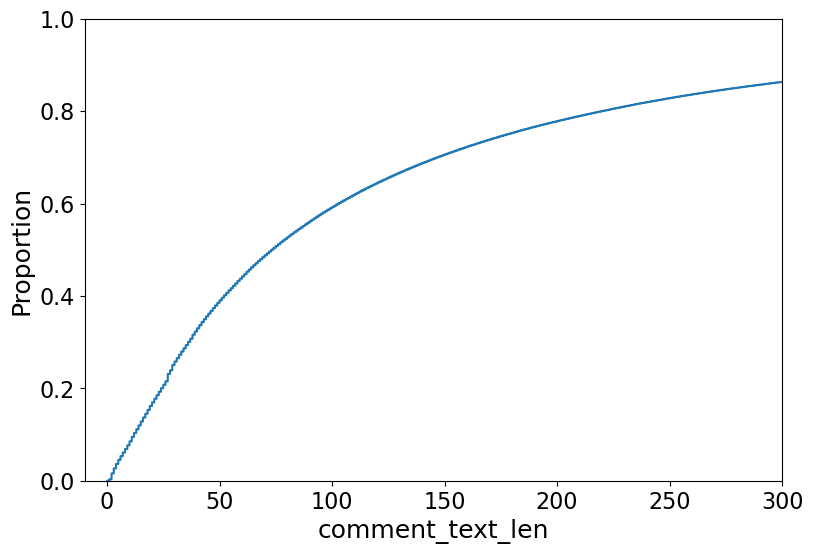

In [9]:
ax = sns.ecdfplot(
    data=d_dfs['df_comments_meta'],
    x='comment_text_len',
)
ax.set_xlim(-10, 300)

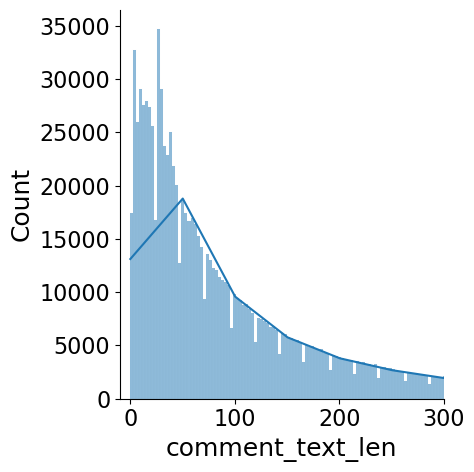

In [10]:
g = sns.displot(
    data=d_dfs['df_comments_meta'],
    x='comment_text_len',
    kde=True,
)
g.set(xlim=(-10, 300))

## How many words do we usually see in comments with text-len 10 or 11?

In [11]:
style_df_numeric(
    d_dfs['df_comments_meta']
    [d_dfs['df_comments_meta']['comment_text_len'] == 10]
    [['comment_text_len', 'comment_text_word_count']].describe()
)

,comment_text_len,comment_text_word_count
count,"9,575.00","9,575"
mean,10.00,2
std,0.00,1
min,10.00,0
25%,10.00,1
50%,10.00,2
75%,10.00,2
max,10.00,5


In [12]:
style_df_numeric(
    d_dfs['df_comments_meta']
    [d_dfs['df_comments_meta']['comment_text_len'] == 11]
    [['comment_text_len', 'comment_text_word_count']].describe()
)

,comment_text_len,comment_text_word_count
count,"10,701.00","10,701"
mean,11.00,2
std,0.00,1
min,11.00,0
25%,11.00,2
50%,11.00,2
75%,11.00,2
max,11.00,6


# Kick off sample job to load vectors & metadata [deprecated]

2021-08-04: We no longer need to load the dfs and keep them in memory to do quick tests. Instead use the two new parameters to limit how many files to read:
- `n_sample_posts_files`
- `n_sample_comments_files`

---
Legacy:
Loading the vectors/embeddings & metadat can take 5+ minutes each run.
So we're loading the data only once so that it's faster to test/iterate on different parameters.

It might've been slower before because I was reading from one large file. Let's see if it's better now that it's reading from multiple files at the same time (they should be read in parallel).
```
16:14:35 | INFO | "-- Start _load_raw_embeddings() method --"
16:14:35 | INFO | "Loading subreddit description embeddings..."
16:14:36 | INFO | "  (629, 512) <- Raw vectorized subreddit description shape"
16:14:36 | INFO | "Loading POSTS embeddings..."
16:15:12 | INFO | "  (262226, 512) <- Raw POSTS shape"
16:15:12 | INFO | "Loading COMMENTS embeddings..."
16:17:03 | INFO | "  (1108757, 512) <- Raw COMMENTS shape"
16:17:03 | INFO | "  Keep only comments for posts with embeddings"
16:17:04 | INFO | "  (1108757, 512) <- COMMENTS shape, after keeping only existing posts"
16:17:06 | INFO | "  0:02:30.685528 <- Total raw embeddings load time elapsed"
```

In [ ]:
%%time

mlflow.end_run("FAILED")

job_agg = AggregateEmbeddings(
    run_name=f"test_new_class-{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    **config_test_full_lc_false.config_flat
)

job_agg._load_raw_embeddings()
job_agg._load_metadata()

d_dfs = dict()
(
    d_dfs['df_v_sub'], d_dfs['df_v_posts'], d_dfs['df_v_comments'],
    d_dfs['df_subs_meta'], d_dfs['df_posts_meta'], d_dfs['df_comments_meta'],
    
) = (
    job_agg.df_v_sub, job_agg.df_v_posts, job_agg.df_v_comments,
    job_agg.df_subs_meta, job_agg.df_posts_meta, job_agg.df_comments_meta,
)

## Check shape & memory usage for main dfs

Some of these methods don't work for dask dfs... sigh.

In [ ]:
for k, df_ in d_dfs.items():
    print(f"\n{k}")
    try:
        print(f"{df_.shape} <- df shape")
        if 'meta' in k:
            # meta is expected to be usually pandas df
            df_.info()
            # df_.info(memory_usage='deep')
#             print(f"  {df_.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
            
        else:
            df_.info()
            # df_.info(memory_usage='deep')
#             print(f"  {df_.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
            # display(df_.iloc[:5, :15])
    except (AttributeError, TypeError):
        pass

# Test: download & loading files with new function
The first time we call the function, it'll download the files, and after that it should read the local (cached) file.

## Sub descriptions

In [34]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['subreddit_desc_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['subreddit_desc_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)


08:49:14 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_subreddits_description"


  0%|          | 0/4 [00:00<?, ?it/s]

08:49:14 | INFO | "  _common_metadata <- File already exists, not downloading"
08:49:14 | INFO | "  _metadata <- File already exists, not downloading"
08:49:14 | INFO | "  manual_meta-3767_by_514.txt <- File already exists, not downloading"
08:49:14 | INFO | "  part.0.parquet <- File already exists, not downloading"


CPU times: user 596 ms, sys: 5.88 ms, total: 602 ms
Wall time: 733 ms


,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_270,embeddings_271,e

## Post Embeddings
Without caching, it takes around 30-seconds to load the df.

In [16]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['posts_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['posts_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)

09:22:38 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"


  0%|          | 0/51 [00:00<?, ?it/s]

CPU times: user 638 ms, sys: 52 ms, total: 690 ms
Wall time: 1.05 s


,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_270,embeddin

In [17]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['posts_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['posts_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)

09:23:59 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"


  0%|          | 0/51 [00:00<?, ?it/s]

CPU times: user 625 ms, sys: 16.7 ms, total: 642 ms
Wall time: 779 ms


,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_270,embeddin

## Comment embeddings
From almost 6 minutes to less than one second!

```
# 1st run (download)
38/38 [05:51<00:00, 6.34s/it] 100%
CPU times: user 4min 12s, sys: 1min 21s, total: 5min 34s
Wall time: 5min 52s


# subsequent run (after chaching)
38/38 [00:00<00:00, 1550.48it/s] 100%
CPU times: user 634 ms, sys: 4.37 ms, total: 638 ms
Wall time: 786 ms

```



In [18]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['comments_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['comments_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)

09:24:08 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/10/e66c5db26bd64f6da09c012eea700d0a/artifacts/df_vect_comments"


  0%|          | 0/38 [00:00<?, ?it/s]

CPU times: user 4min 12s, sys: 1min 21s, total: 5min 34s
Wall time: 5min 52s


,subreddit_name,subreddit_id,post_id,comment_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_2

In [19]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['comments_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['comments_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)

09:30:01 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/10/e66c5db26bd64f6da09c012eea700d0a/artifacts/df_vect_comments"


  0%|          | 0/38 [00:00<?, ?it/s]

CPU times: user 634 ms, sys: 4.37 ms, total: 638 ms
Wall time: 786 ms


,subreddit_name,subreddit_id,post_id,comment_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_2